# Lesson5 画像からキャプションを生成してみよう

## 目次
- Section1 解説
    - 1.1 キャプション生成とは?
    - 1.2 条件付き言語モデルとしての位置づけ
    - 1.3 データセット
        - MS-COCO
    - 1.4 ネットワーク構成
        - Encoder (CNN)
        - Decoder (RNN)
- Section 2 実装①
    - 2.1 MS-COCOデータでキャプション生成
- Section 3 テクニック・発展的内容
    - 3.1 Attention
    - 3.2 Beam Search
- Section 4 実装②
    - CNN-LSTM with Attention
- Section 5 ケーススタディ

## Section1 解説

### 1.1 キャプション生成とは
**キャプション生成** とは, 画像を入力としてその画像の説明文（キャプション）を出力するタスクです.

以下イメージです.

<img src="../figures/cap_gen_image.png" width="500m">
出典: O. Vinyals et al. Show and Tell: A Neural Image Caption Generator. CVPR 2015

研究の意義としては, 例えば視覚障害のある人にWeb上にある画像の内容を理解させるために自動で説明文を生成する, といったことなどが考えられます.

基本的なネットワーク構成としては, 画像の特徴量をCNNにより抽出し, その特徴量をもとにRNNで説明文を生成していく形になります.

### 1.2 前Lesson（翻訳モデル）との関係性

前Lessonで学んだ翻訳モデルとの関係性を考えてみます.

翻訳モデルでは, Encoder (RNN) で元言語文の特徴を抽出し, その抽出した特徴をもとにDecoder (RNN) でターゲット言語の文を生成していました.

キャプション生成のモデルでも基本的な構造は同じです. CNNで画像の特徴を抽出し, その特徴をもとに説明文を生成します.

翻訳タスクもキャプション生成タスクも、同じ言語生成という広いくくりのタスクとして俯瞰することができます.

これらの違いは、どのようにDecoder側の言語モデルの初期状態 (具体的にはRNNであれば最初の隠れ層$h_0$) を条件付けるかという部分です.

こういったように、問題設定をうまく工夫することで、一口に言語生成といっても要約・対話などさまざまなタスクに対処できるようになります.

他にも次の表のような例があります.

<img src="../figures/clm.png" width="600mm">

出典: C. Dyer. "Conditional Language Modeling" in Deep Natural Language Procedding 2017 at Oxford. https://github.com/oxford-cs-deepnlp-2017/lectures

問題設定が変わったからと言って大幅にモデルが変わってしまうということもありません。

具体的には、キャプション生成のモデルでは入力情報が画像となるので、EncoderをCNNに変更するだけで良いわけです.

（翻訳モデルでは入力情報が文でしたので、系列に特化したRNNを特徴抽出に用いていました.）

後述するAttentionの利用についても, 同じように元情報の特徴量に対して適用するという構図は同じです.

翻訳では元文の各隠れ層状態を参考にAttentionを適用していましたが, キャプション生成では元画像のCNNの出力の各ピクセルに対して適用していきます.

### 1.3 データセット

キャプション生成のタスクにおいてもいくつか代表的なデータセットがありますが, 今回はそのうちの１つのMS-COCOとよばれるものを使います.

MS-COCOでは画像に対してキャプションや画像内の物体のラベル等が付いています.

日本語に翻訳された物もあります (https://github.com/STAIR-Lab-CIT/STAIR-captions)

今回の演習ではMS-COCOに事前に前処理をして構築し少し縮小した(画像, キャプション)10000ペア(train:9000, valid:1000)のデータセットを使います.

中身を少し見てみます.

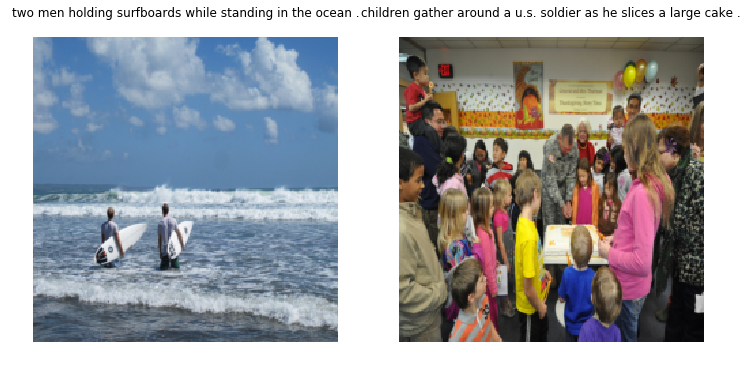

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np

data_y = list(open('/root/userspace/public/lesson5/data/mscoco_captions_1000.txt'))[:2]
data_x = np.load('/root/userspace/public/lesson5/data/mscoco_images_1000.npy')[:2]

plt.figure(figsize=(12, 8))
for i, (x, y) in enumerate(zip(data_x, data_y)):
    plt.subplot(1, 2, i+1)
    plt.imshow(x)
    plt.title(y)
    plt.axis('off')
plt.show()

### 1.4 ネットワーク構成

#### 1.4.1 概要
今回のキャプション生成では, 上述の通り, 画像の特徴量の抽出にCNN, 説明文の生成にRNNを用います.

![cap_gen_image](../figures/cap_gen_image.png)
[Show and Tell: A Neural Image Caption Generator](https://arxiv.org/pdf/1411.4555.pdf)

#### 1.4.2 Encoder
CNN (VGGNet) を使用します.
ここで, 事前に大規模なデータセット (ImageNet) で学習されたモデルの重みを利用 (転移) します.
これは`Keras.applications`から読み込むことができます.

VGG16の引数としては, `weights`, `include_top`, `input_tensor`の3つがあります.
- weights: 重みの種類を指定します. ここでは, ImageNetで学習した重みを使用します。重みを指定せずに自分で重みを学習することも出来ますが, 学習には大量の画像が必要となるなどコストがかかります.
- include_top: VGG16の出力層を含むかどうかを決定します. ここではあくまでも特徴抽出器として使いたいので含みません.
- input_tensor: 入力画像のサイズを指定します.

また, 今回のモデルでの学習時にはこのCNNの重みの更新は行いません.
学習を容易にする (学習パラメータの数を減らす) ためです.

具体的な実装はSection 2にて行います.

In [2]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input

x = Input(shape=(224,224,3))
model = VGG16(
    weights='imagenet', 
    include_top=False,
    input_tensor=x)

Using TensorFlow backend.


ネットワーク構成の確認は`.summary()`でできます.

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

#### 1.4.3 Decoder
ここでは翻訳モデルと同様にLSTMを用います.
LSTMの隠れ層とメモリセルの初期状態$h_0$, $c_0$はEncoder(CNN)の出力を元に決定します.

### 1.5 Checkクイズ
問1. キャプション生成におけるネットワークの流れとして適切なものを選択肢から一つ選びなさい.

  ① Encoder(CNN)の出力は, Decoder(RNN)に初期状態$h_0$として入力される
  
  ② Encoder(CNN)の出力は, Decoder(RNN)に最初の単語の埋め込みベクトルとして入力される

1. 2